# Optimization WFA - Logistic Regression

## Logistic Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [3]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
plt.style.use("seaborn-v0_8")

In [5]:
from backtesting import Strategy

In [6]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [7]:
XAUUSD = load_data()

In [8]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [9]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


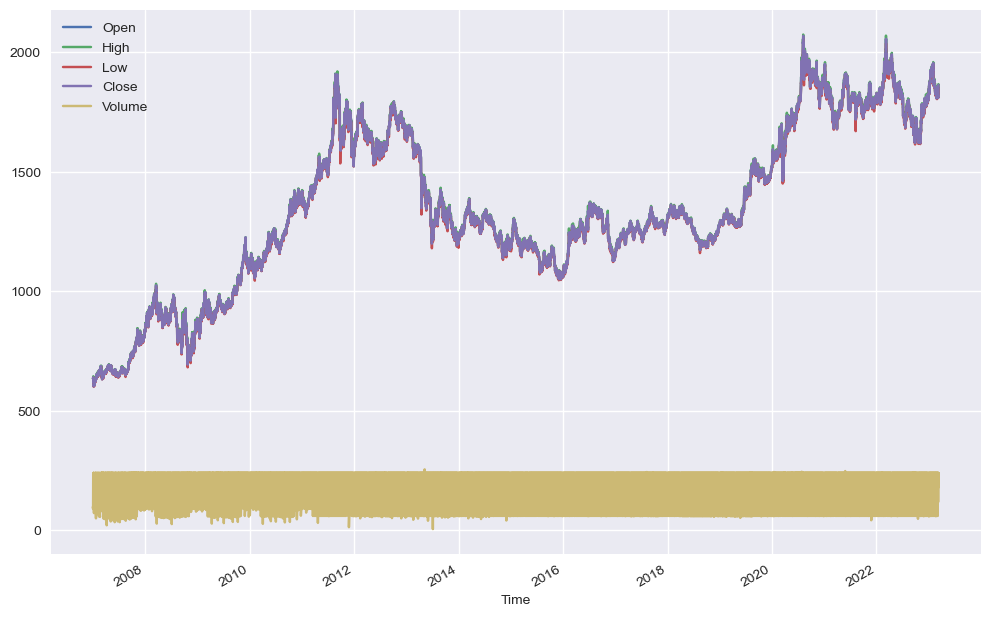

In [10]:
XAUUSD['H4'].plot(figsize=(12, 8))
plt.show()

## ML

### Class and Strategy ML

In [8]:
class Logistic_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [9]:
mainFolder = 'Machine_Learning'
strategy = Logistic_Regression
strategyName = 'Logistic_Regressionon'
account_size = 10000
folder_ML_Strategy = 'Logistic Regression'
subFolder = 'Optimization'

In [10]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data['returns_signal'] = data['returns'].shift(-1)
        data["direction"] = np.sign(data.returns_signal)
        # data.dropna(inplace=True)
        cols = []
        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        # data.dropna(inplace=True)
        data.fillna(0, inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size  :i ]

            lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr")
            lm.fit(rolling_window_data[cols], rolling_window_data['direction'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100 ,commission=0.0002)
        result = backtest.run()
        return result

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [14]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'D1'

### Window size 1 year

In [15]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [16]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [17]:
test = ml.Run()

In [18]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   94.983145
Equity Final [$]                 10244.933631
Equity Peak [$]                   10764.70142
Return [%]                           2.449336
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.120992
Volatility (Ann.) [%]                2.023916
Sharpe Ratio                         0.059781
Sortino Ratio                        0.083256
Calmar Ratio                         0.011954
Max. Drawdown [%]                  -10.121498
Avg. Drawdown [%]                   -0.945082
Max. Drawdown Duration     2683 days 00:00:00
Avg. Drawdown Duration      155 days 00:00:00
# Trades                                 1790
Win Rate [%]                        50.502793
Best Trade [%]                      14.777164
Worst Trade [%]                    -14.061464
Avg. Trade [%]                    

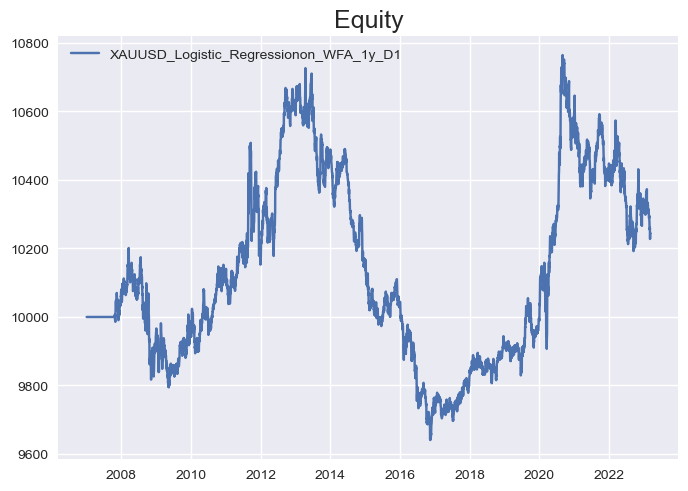

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [20]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [21]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [22]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [23]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [24]:
test = ml.Run()

In [25]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   89.986119
Equity Final [$]                   10460.5451
Equity Peak [$]                  10707.980067
Return [%]                           4.605451
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.225247
Volatility (Ann.) [%]                1.976253
Sharpe Ratio                         0.113977
Sortino Ratio                        0.161477
Calmar Ratio                         0.023409
Max. Drawdown [%]                    -9.62212
Avg. Drawdown [%]                   -0.866097
Max. Drawdown Duration     3610 days 00:00:00
Avg. Drawdown Duration      176 days 00:00:00
# Trades                                 1344
Win Rate [%]                        51.041667
Best Trade [%]                      10.257333
Worst Trade [%]                    -12.452134
Avg. Trade [%]                    

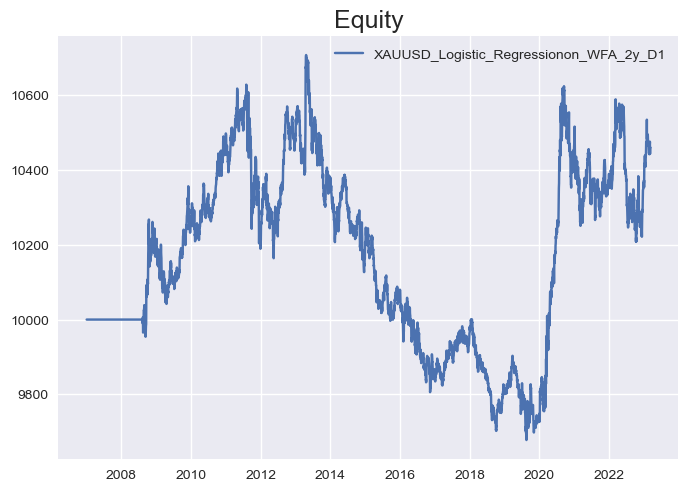

In [26]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [27]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [28]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [29]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [30]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [31]:
test = ml.Run()

In [32]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   84.989094
Equity Final [$]                 10722.115035
Equity Peak [$]                  11217.725263
Return [%]                            7.22115
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.349017
Volatility (Ann.) [%]                1.831073
Sharpe Ratio                         0.190608
Sortino Ratio                        0.271668
Calmar Ratio                         0.066083
Max. Drawdown [%]                   -5.281471
Avg. Drawdown [%]                   -0.549235
Max. Drawdown Duration     2666 days 00:00:00
Avg. Drawdown Duration      101 days 00:00:00
# Trades                                 1075
Win Rate [%]                             52.0
Best Trade [%]                      17.721405
Worst Trade [%]                    -13.814162
Avg. Trade [%]                    

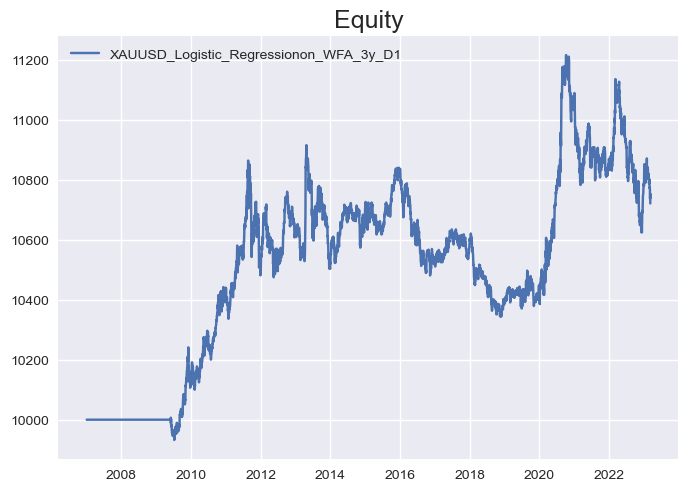

In [33]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [34]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [35]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [36]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [37]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [38]:
test = ml.Run()

In [39]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   79.992068
Equity Final [$]                 11068.752097
Equity Peak [$]                  11305.659148
Return [%]                          10.687521
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.508692
Volatility (Ann.) [%]                1.815723
Sharpe Ratio                          0.28016
Sortino Ratio                        0.392385
Calmar Ratio                         0.071129
Max. Drawdown [%]                   -7.151665
Avg. Drawdown [%]                   -0.524277
Max. Drawdown Duration     3272 days 00:00:00
Avg. Drawdown Duration      102 days 00:00:00
# Trades                                  997
Win Rate [%]                        53.059178
Best Trade [%]                      46.923787
Worst Trade [%]                     -7.751037
Avg. Trade [%]                    

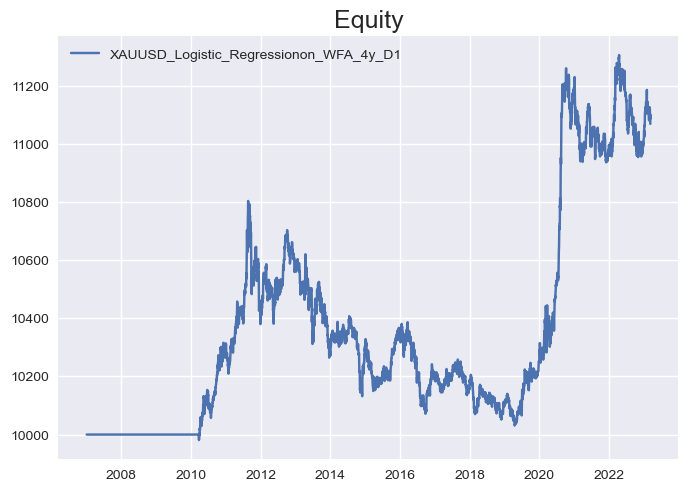

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [41]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [42]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [43]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [44]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [45]:
test = ml.Run()

In [46]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   74.995043
Equity Final [$]                  9203.301592
Equity Peak [$]                  10533.471934
Return [%]                          -7.966984
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.414008
Volatility (Ann.) [%]                1.939829
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -14.967758
Avg. Drawdown [%]                   -1.127201
Max. Drawdown Duration     4218 days 00:00:00
Avg. Drawdown Duration      260 days 00:00:00
# Trades                                  961
Win Rate [%]                        51.404787
Best Trade [%]                      17.718949
Worst Trade [%]                    -11.871158
Avg. Trade [%]                    

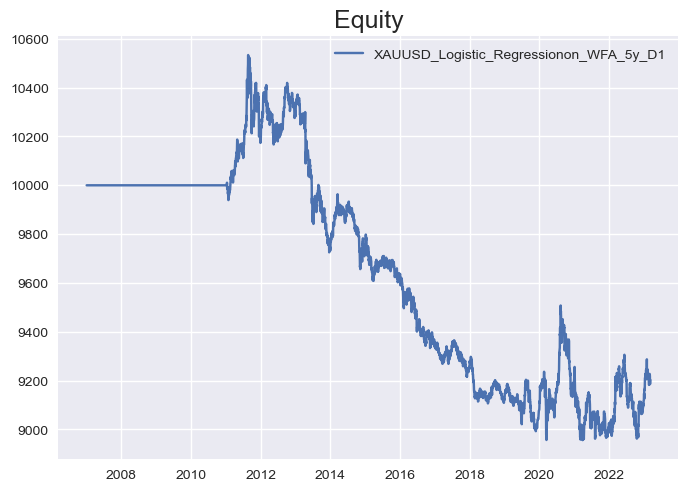

In [47]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [48]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [49]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [50]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [51]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [52]:
test = ml.Run()

In [53]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   69.998017
Equity Final [$]                  8260.802305
Equity Peak [$]                  10097.572371
Return [%]                         -17.391977
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.950205
Volatility (Ann.) [%]                1.941666
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -20.217284
Avg. Drawdown [%]                   -3.888278
Max. Drawdown Duration     3809 days 00:00:00
Avg. Drawdown Duration      691 days 00:00:00
# Trades                                  912
Win Rate [%]                        49.780702
Best Trade [%]                       5.357556
Worst Trade [%]                    -15.262191
Avg. Trade [%]                    

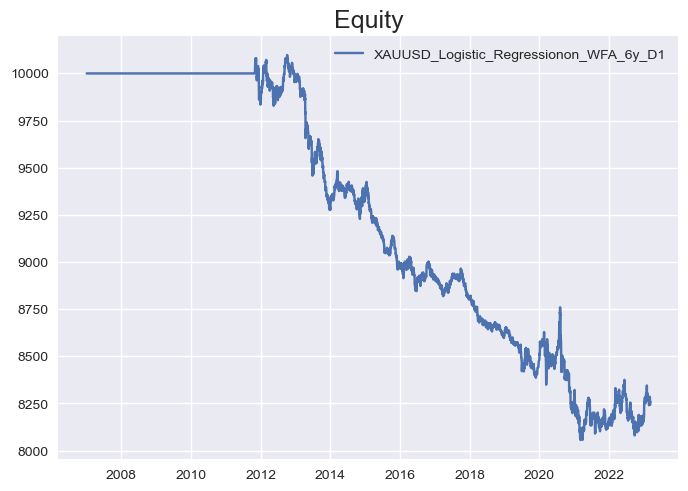

In [54]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [55]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [56]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [57]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [58]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [59]:
test = ml.Run()

In [60]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   65.000991
Equity Final [$]                   8564.34632
Equity Peak [$]                   10123.56531
Return [%]                         -14.356537
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.771435
Volatility (Ann.) [%]                1.798308
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.489122
Avg. Drawdown [%]                   -2.142128
Max. Drawdown Duration     3809 days 00:00:00
Avg. Drawdown Duration      480 days 00:00:00
# Trades                                  888
Win Rate [%]                        49.436937
Best Trade [%]                       8.160297
Worst Trade [%]                    -12.208499
Avg. Trade [%]                    

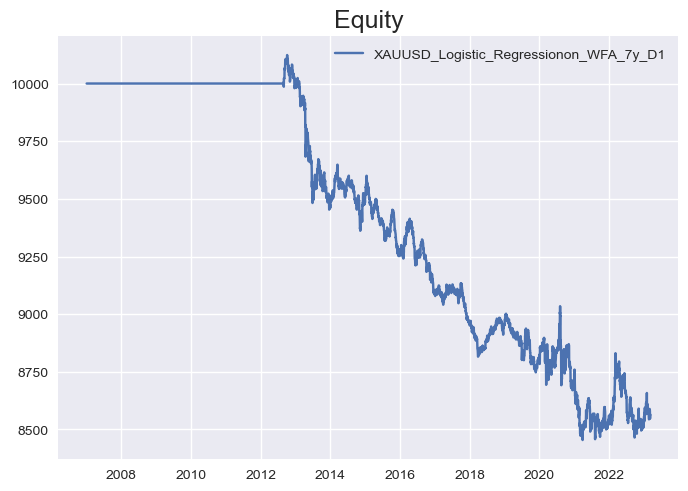

In [61]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [62]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [63]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [64]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [65]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [66]:
test = ml.Run()

In [67]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   60.003966
Equity Final [$]                   9367.86409
Equity Peak [$]                  10008.622253
Return [%]                          -6.321359
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.325774
Volatility (Ann.) [%]                1.606891
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -8.745649
Avg. Drawdown [%]                    -5.30158
Max. Drawdown Duration     3482 days 00:00:00
Avg. Drawdown Duration     1778 days 00:00:00
# Trades                                  880
Win Rate [%]                        52.386364
Best Trade [%]                       7.677108
Worst Trade [%]                     -8.100709
Avg. Trade [%]                    

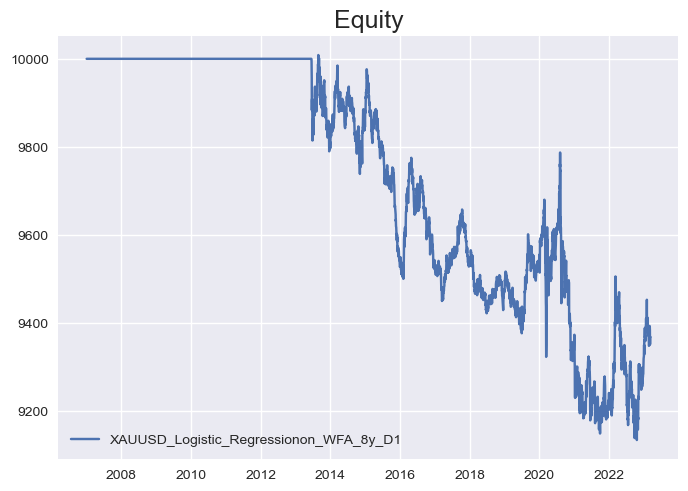

In [68]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [69]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [70]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [71]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H4'

### Window size 1 year

In [72]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [73]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [74]:
test = ml.Run()

In [75]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   94.175393
Equity Final [$]                  9270.841172
Equity Peak [$]                   11670.97291
Return [%]                          -7.291588
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.377615
Volatility (Ann.) [%]                1.921571
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -21.374107
Avg. Drawdown [%]                   -0.255087
Max. Drawdown Duration     4207 days 12:00:00
Avg. Drawdown Duration       25 days 21:00:00
# Trades                                 8651
Win Rate [%]                        53.300197
Best Trade [%]                       6.707181
Worst Trade [%]                     -7.445637
Avg. Trade [%]                    

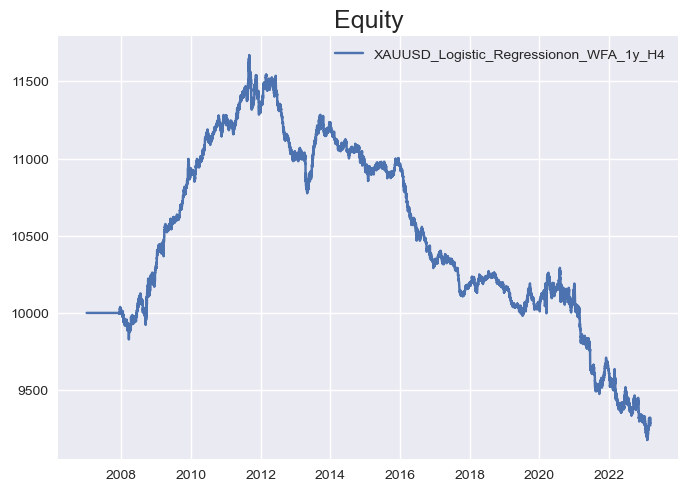

In [76]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [77]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [78]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [79]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [80]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [81]:
test = ml.Run()

In [82]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   88.354635
Equity Final [$]                  9853.408315
Equity Peak [$]                  11520.679036
Return [%]                          -1.465917
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.073767
Volatility (Ann.) [%]                1.786373
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -15.87026
Avg. Drawdown [%]                   -0.203517
Max. Drawdown Duration     4207 days 12:00:00
Avg. Drawdown Duration       24 days 06:00:00
# Trades                                 7658
Win Rate [%]                        55.510577
Best Trade [%]                       3.550015
Worst Trade [%]                     -6.502605
Avg. Trade [%]                    

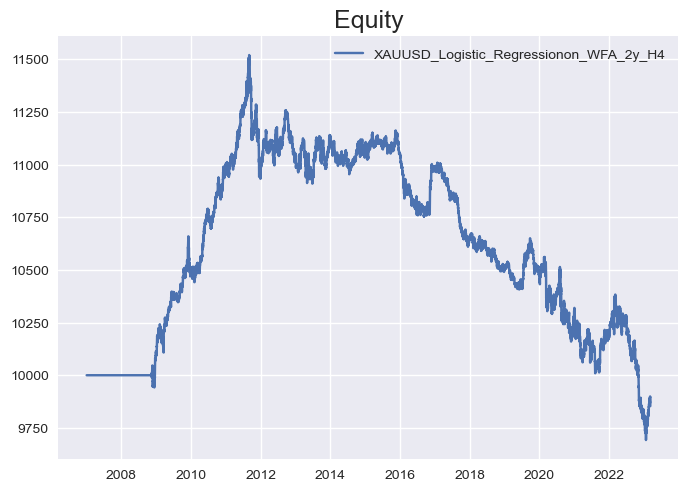

In [83]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [84]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [85]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [86]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [87]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [88]:
test = ml.Run()

In [89]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   82.533877
Equity Final [$]                  8551.759553
Equity Peak [$]                  11155.687454
Return [%]                         -14.482404
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.778727
Volatility (Ann.) [%]                1.877147
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.852694
Avg. Drawdown [%]                   -0.291361
Max. Drawdown Duration     4203 days 08:00:00
Avg. Drawdown Duration       33 days 18:00:00
# Trades                                 6590
Win Rate [%]                        55.644917
Best Trade [%]                       3.550015
Worst Trade [%]                     -8.089438
Avg. Trade [%]                    

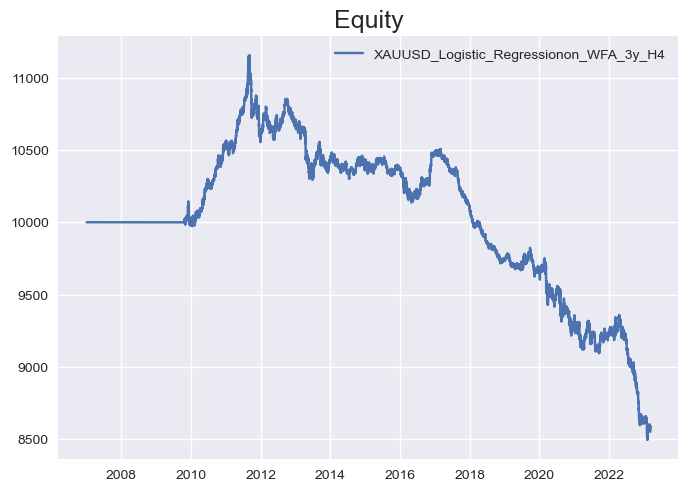

In [90]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [91]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [92]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [93]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [94]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [95]:
test = ml.Run()

In [96]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                    76.71312
Equity Final [$]                  8443.197333
Equity Peak [$]                  10745.273344
Return [%]                         -15.568027
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.842052
Volatility (Ann.) [%]                1.876544
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -21.785615
Avg. Drawdown [%]                   -0.406948
Max. Drawdown Duration     4207 days 12:00:00
Avg. Drawdown Duration       53 days 06:00:00
# Trades                                 5740
Win Rate [%]                        57.003484
Best Trade [%]                       4.645761
Worst Trade [%]                     -8.089438
Avg. Trade [%]                    

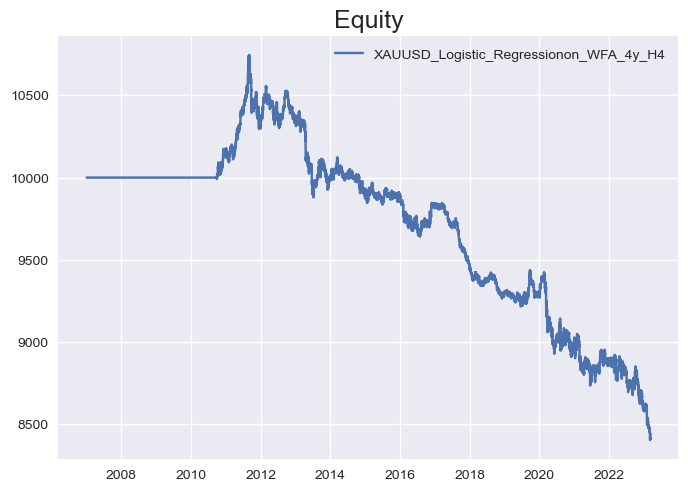

In [97]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [98]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [99]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [100]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [101]:
ml = ML_Regression(data, strategy, start_train,
                   end_train, TF, window_size, 500)

In [102]:
test = ml.Run()

In [103]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                    9.916846
Equity Final [$]                          0.0
Equity Peak [$]                    535.844541
Return [%]                             -100.0
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               84.734402
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -26.033725
Max. Drawdown Duration     4203 days 08:00:00
Avg. Drawdown Duration     1051 days 17:00:00
# Trades                                  476
Win Rate [%]                        51.890756
Best Trade [%]                       3.233966
Worst Trade [%]                     -6.146485
Avg. Trade [%]                    

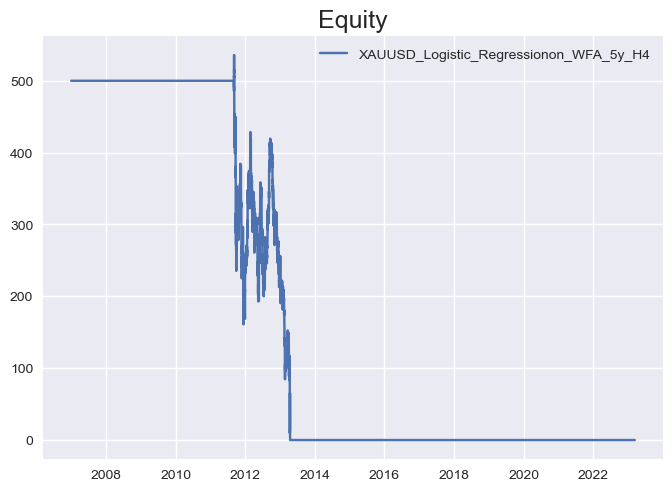

In [104]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [105]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [106]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [107]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [108]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [109]:
test = ml.Run()

In [110]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   65.071605
Equity Final [$]                  7611.344996
Equity Peak [$]                  10110.441438
Return [%]                          -23.88655
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -1.354655
Volatility (Ann.) [%]                1.847644
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -24.717976
Avg. Drawdown [%]                   -1.656429
Max. Drawdown Duration     3808 days 16:00:00
Avg. Drawdown Duration      241 days 03:00:00
# Trades                                 4805
Win Rate [%]                        57.585848
Best Trade [%]                       3.359645
Worst Trade [%]                     -8.089438
Avg. Trade [%]                    

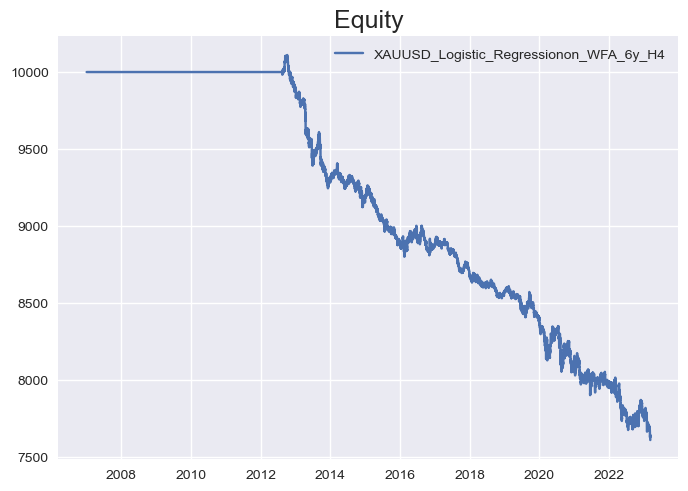

In [111]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [112]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [113]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [114]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [115]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [116]:
test = ml.Run()

In [117]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   59.250847
Equity Final [$]                  8795.717367
Equity Peak [$]                   10145.13324
Return [%]                         -12.042826
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.639168
Volatility (Ann.) [%]                1.621602
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -14.075855
Avg. Drawdown [%]                    -1.05017
Max. Drawdown Duration     3475 days 04:00:00
Avg. Drawdown Duration      234 days 05:00:00
# Trades                                 4641
Win Rate [%]                        59.297565
Best Trade [%]                       2.971408
Worst Trade [%]                     -7.255205
Avg. Trade [%]                    

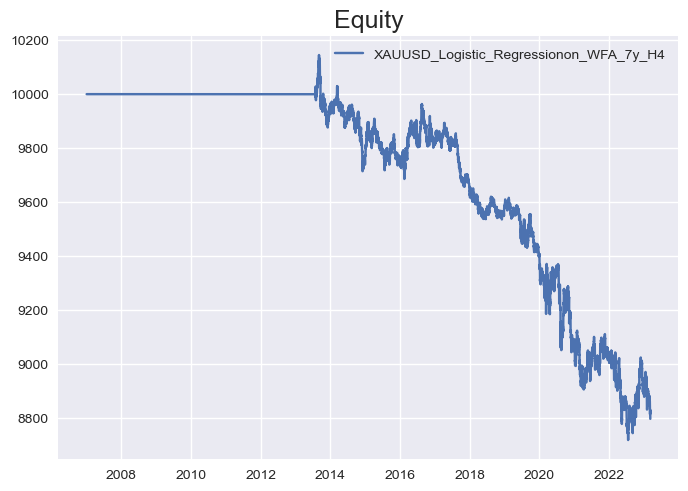

In [118]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [119]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [120]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [121]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [122]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [123]:
test = ml.Run()

In [124]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   53.430089
Equity Final [$]                  8463.338177
Equity Peak [$]                  10043.552685
Return [%]                         -15.366618
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.830245
Volatility (Ann.) [%]                1.568126
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -15.733621
Avg. Drawdown [%]                   -2.109068
Max. Drawdown Duration     3130 days 12:00:00
Avg. Drawdown Duration      395 days 22:00:00
# Trades                                 4278
Win Rate [%]                        59.046283
Best Trade [%]                       2.621148
Worst Trade [%]                     -7.255205
Avg. Trade [%]                    

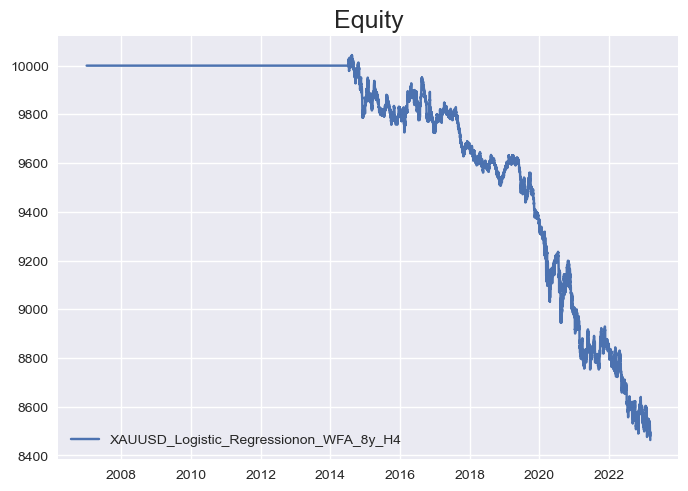

In [125]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [126]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [127]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [11]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H1'

### Window size 1 year

In [12]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [13]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [14]:
test = ml.Run()

In [15]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   93.824652
Equity Final [$]                  3032.049477
Equity Peak [$]                  10223.327649
Return [%]                         -69.679505
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -5.788866
Volatility (Ann.) [%]                2.966743
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -70.341854
Avg. Drawdown [%]                   -1.089053
Max. Drawdown Duration     4369 days 04:00:00
Avg. Drawdown Duration       71 days 07:00:00
# Trades                                32821
Win Rate [%]                        55.845343
Best Trade [%]                       3.343497
Worst Trade [%]                     -8.803494
Avg. Trade [%]                    

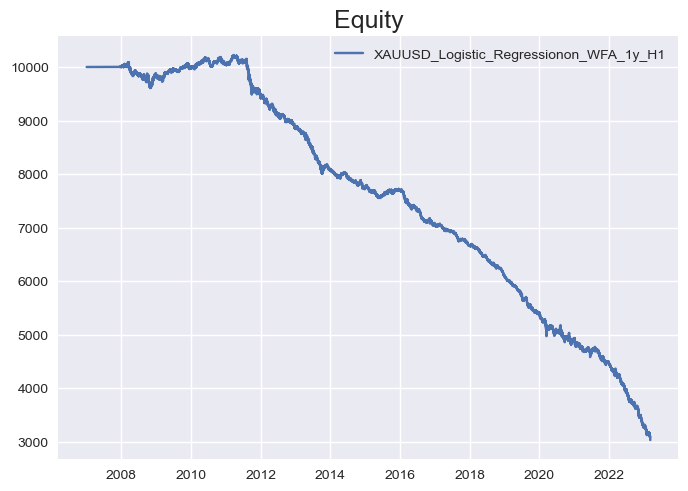

In [16]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [17]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [18]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [19]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [20]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [21]:
test = ml.Run()

In [22]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   87.650326
Equity Final [$]                  4850.929834
Equity Peak [$]                  10867.133296
Return [%]                         -51.490702
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -3.550364
Volatility (Ann.) [%]                2.365731
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -55.42936
Avg. Drawdown [%]                   -0.324247
Max. Drawdown Duration     4279 days 16:00:00
Avg. Drawdown Duration       21 days 06:00:00
# Trades                                28871
Win Rate [%]                        57.129992
Best Trade [%]                       3.343497
Worst Trade [%]                     -5.258851
Avg. Trade [%]                    

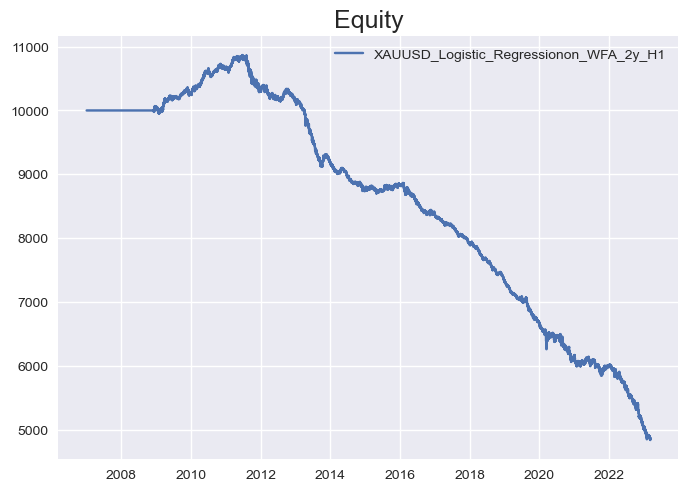

In [23]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [24]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [25]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [26]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [27]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [28]:
test = ml.Run()

In [29]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   81.475999
Equity Final [$]                  4845.491484
Equity Peak [$]                    10681.5283
Return [%]                         -51.545085
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                    -3.55577
Volatility (Ann.) [%]                 2.38827
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -54.835398
Avg. Drawdown [%]                   -0.329489
Max. Drawdown Duration     4236 days 13:00:00
Avg. Drawdown Duration       21 days 13:00:00
# Trades                                26715
Win Rate [%]                        57.525735
Best Trade [%]                       3.343497
Worst Trade [%]                     -5.176082
Avg. Trade [%]                    

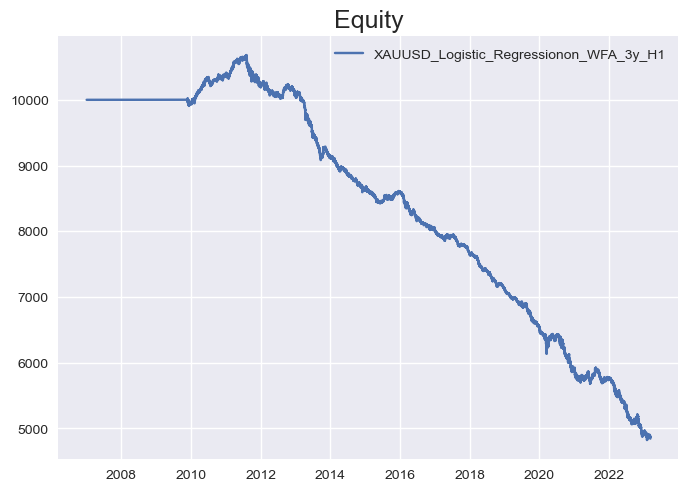

In [30]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [31]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [32]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [33]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [34]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [35]:
test = ml.Run()

In [36]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   75.301672
Equity Final [$]                  4949.878152
Equity Peak [$]                  10384.131324
Return [%]                         -50.501218
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -3.452994
Volatility (Ann.) [%]                2.337229
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -52.610396
Avg. Drawdown [%]                   -0.487045
Max. Drawdown Duration     4236 days 13:00:00
Avg. Drawdown Duration       34 days 21:00:00
# Trades                                25247
Win Rate [%]                        58.204935
Best Trade [%]                       3.273433
Worst Trade [%]                     -5.174514
Avg. Trade [%]                    

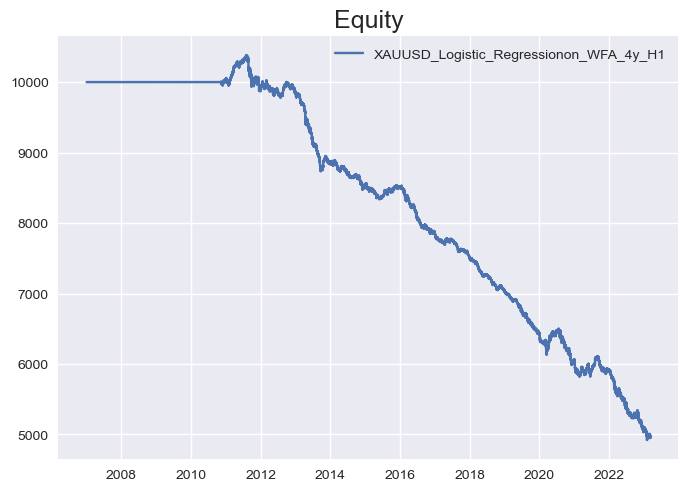

In [37]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [38]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [39]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [40]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [41]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [42]:
test = ml.Run()

In [43]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   69.127345
Equity Final [$]                  4642.331646
Equity Peak [$]                  10045.879205
Return [%]                         -53.576684
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -3.761971
Volatility (Ann.) [%]                2.300762
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -54.029018
Avg. Drawdown [%]                   -5.692268
Max. Drawdown Duration     4113 days 02:00:00
Avg. Drawdown Duration      414 days 21:00:00
# Trades                                23189
Win Rate [%]                        58.381129
Best Trade [%]                       3.273433
Worst Trade [%]                     -5.303194
Avg. Trade [%]                    

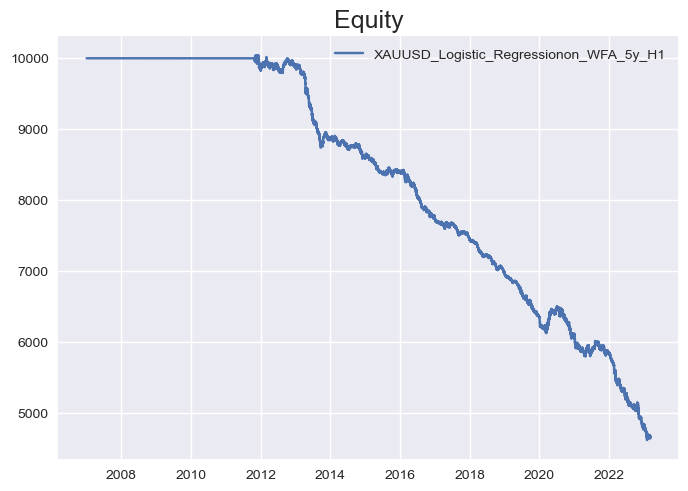

In [44]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [45]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [46]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [47]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [48]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [49]:
test = ml.Run()

In [50]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   62.953019
Equity Final [$]                  4467.209611
Equity Peak [$]                  10054.122603
Return [%]                         -55.327904
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -3.946714
Volatility (Ann.) [%]                2.244759
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -55.568379
Avg. Drawdown [%]                   -3.334878
Max. Drawdown Duration     3759 days 02:00:00
Avg. Drawdown Duration      222 days 18:00:00
# Trades                                21649
Win Rate [%]                        58.265971
Best Trade [%]                       2.946298
Worst Trade [%]                     -5.239532
Avg. Trade [%]                    

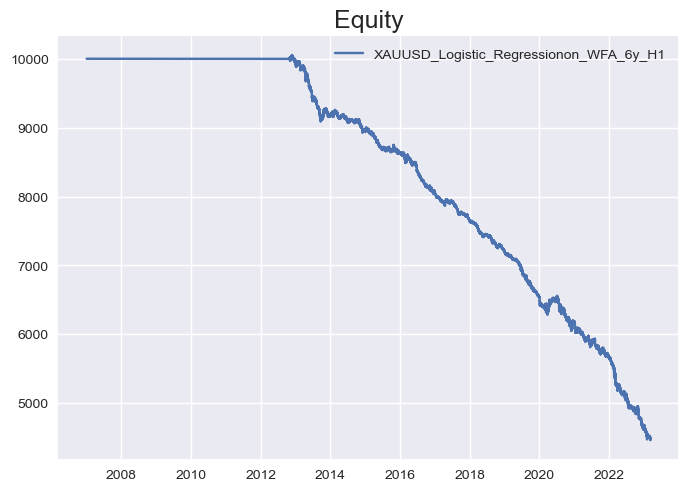

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [52]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [53]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [12]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [13]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [14]:
test = ml.Run()

In [15]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   56.778692
Equity Final [$]                  5189.768932
Equity Peak [$]                  10032.499476
Return [%]                         -48.102311
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                     -3.2244
Volatility (Ann.) [%]                1.985596
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -48.319891
Avg. Drawdown [%]                   -5.436407
Max. Drawdown Duration     3409 days 08:00:00
Avg. Drawdown Duration      380 days 00:00:00
# Trades                                19978
Win Rate [%]                         58.50936
Best Trade [%]                       3.273433
Worst Trade [%]                     -4.970538
Avg. Trade [%]                    

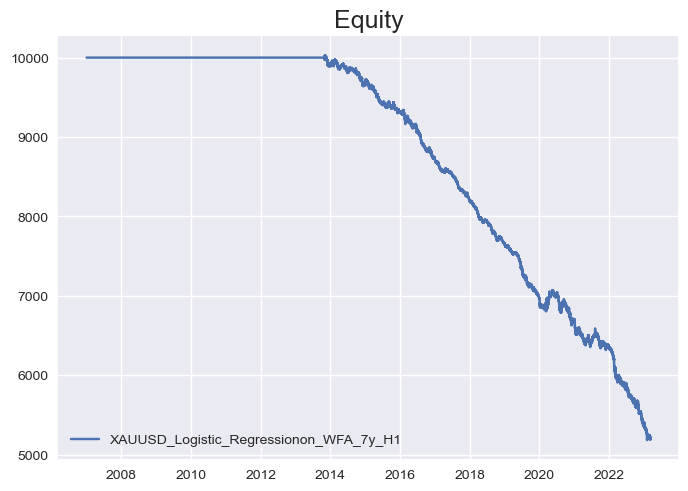

In [16]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [17]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [18]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [19]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [20]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [21]:
test = ml.Run()

In [22]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   50.604365
Equity Final [$]                   5323.73883
Equity Peak [$]                  10010.053106
Return [%]                         -46.762612
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                    -3.10107
Volatility (Ann.) [%]                1.891646
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -46.816078
Avg. Drawdown [%]                  -46.816078
Max. Drawdown Duration     3055 days 02:00:00
Avg. Drawdown Duration     3055 days 02:00:00
# Trades                                18273
Win Rate [%]                        58.424999
Best Trade [%]                       3.273433
Worst Trade [%]                     -4.970538
Avg. Trade [%]                    

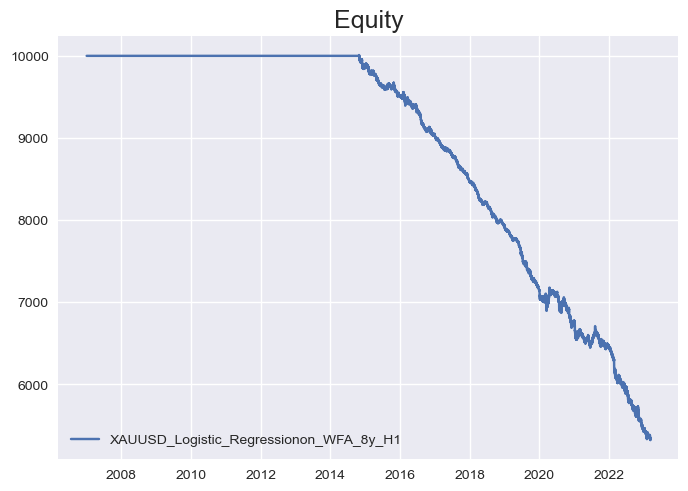

In [23]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [24]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [25]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [11]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'M30'

### Window size 1 year

In [27]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [28]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [29]:
test = ml.Run()

In [30]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   70.775007
Equity Final [$]                    11.597381
Equity Peak [$]                  10006.539959
Return [%]                         -99.884026
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -28.664565
Volatility (Ann.) [%]               12.887861
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.884172
Avg. Drawdown [%]                  -20.003087
Max. Drawdown Duration     5558 days 13:30:00
Avg. Drawdown Duration     1112 days 03:00:00
# Trades                                48380
Win Rate [%]                        55.400992
Best Trade [%]                       3.428308
Worst Trade [%]                     -9.600389
Avg. Trade [%]                    

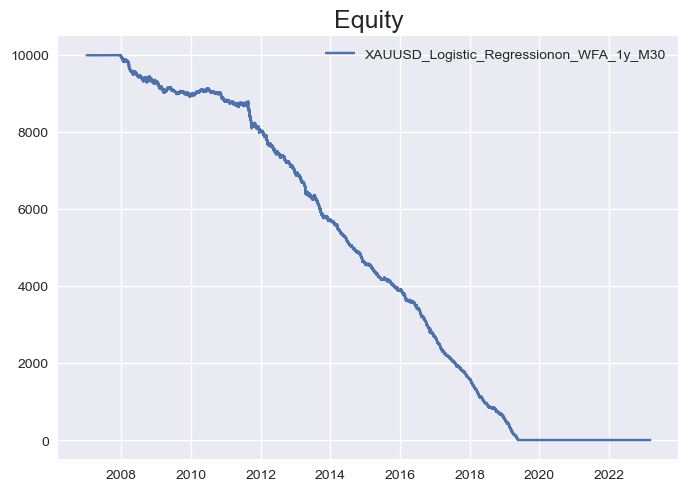

In [31]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [12]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [13]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [14]:
test = ml.Run()

In [15]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   73.827707
Equity Final [$]                    11.606548
Equity Peak [$]                  10052.293409
Return [%]                         -99.883935
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -28.661748
Volatility (Ann.) [%]               21.405181
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.925027
Avg. Drawdown [%]                   -4.214671
Max. Drawdown Duration     5196 days 23:30:00
Avg. Drawdown Duration      217 days 00:22:00
# Trades                                49149
Win Rate [%]                        56.564732
Best Trade [%]                       2.824602
Worst Trade [%]                     -5.608548
Avg. Trade [%]                    

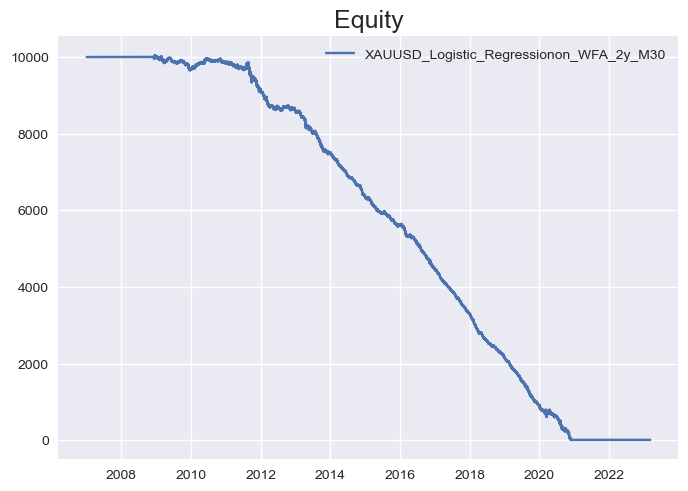

In [16]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [17]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [18]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [19]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [20]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [21]:
test = ml.Run()

In [22]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   70.579859
Equity Final [$]                    11.666463
Equity Peak [$]                  10183.026566
Return [%]                         -99.883335
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -28.643391
Volatility (Ann.) [%]               46.447327
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -99.91726
Avg. Drawdown [%]                   -2.134693
Max. Drawdown Duration     4216 days 23:30:00
Avg. Drawdown Duration       97 days 01:50:00
# Trades                                45826
Win Rate [%]                        57.214245
Best Trade [%]                       2.824602
Worst Trade [%]                     -5.608548
Avg. Trade [%]                    

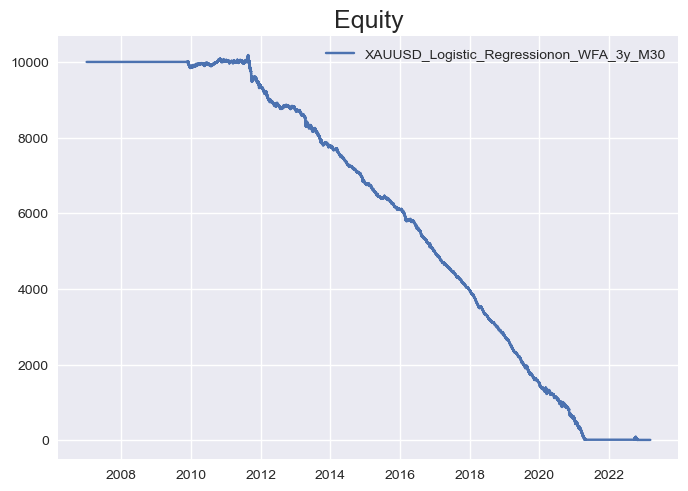

In [23]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [24]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [25]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [26]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [27]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [29]:
test = ml.Run()

In [30]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   64.246019
Equity Final [$]                    14.453236
Equity Peak [$]                  10012.221883
Return [%]                         -99.855468
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -27.875514
Volatility (Ann.) [%]                24.97448
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.910637
Avg. Drawdown [%]                  -24.985854
Max. Drawdown Duration     4502 days 08:00:00
Avg. Drawdown Duration     1125 days 15:15:00
# Trades                                41219
Win Rate [%]                        57.502608
Best Trade [%]                       2.824602
Worst Trade [%]                     -5.140518
Avg. Trade [%]                    

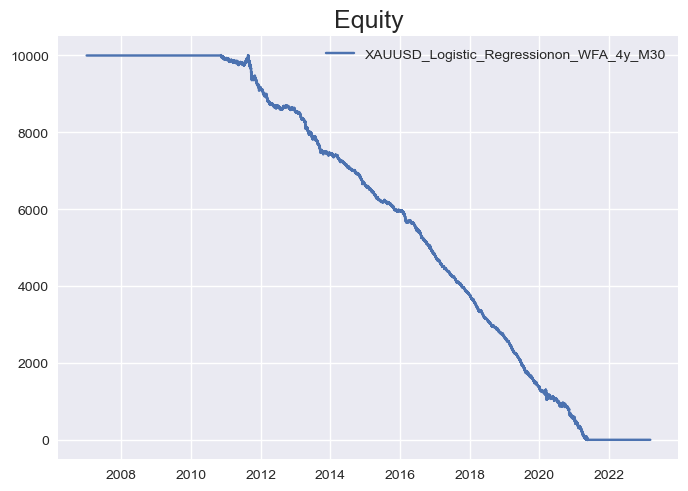

In [31]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [32]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [33]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [12]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [13]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [14]:
test = ml.Run()

KeyboardInterrupt: 

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48
WFA = '7y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')